In [1]:
import math                      # providing access to the mathematical functions defined by the C standard
import matplotlib.pyplot as plt  # plotting library
import scipy                     # scientific computnig and technical computing
import cv2                       # working with, mainly resizing, images
import numpy as np               # dealing with arrays
import glob                      # return a possibly-empty list of path names that match pathname
import os                        # dealing with directories
import pandas as pd              # providing data structures and data analysis tools
import tensorflow as tf       
import itertools
import random
from random import shuffle       # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm            # a nice pretty percentage bar for tasks. Thanks to viewer Daniel Bühler for this suggestion
from PIL import Image
from scipy import ndimage
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
%matplotlib inline
np.random.seed(1)

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


In [8]:
root = 'D:/datasets/monkey'

train_dir = Path(f'{root}/training')
test_dir = Path(f'{root}/validation')

In [10]:
#label info
cols = ['Label','Latin Name', 'Common Name','Train Images', 'Validation Images']
labels = pd.read_csv(f"{root}/monkey_labels.txt", names=cols, skiprows=1)
labels

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


In [11]:
labels = labels['Common Name']
labels

0     mantled_howler                
1     patas_monkey                  
2     bald_uakari                   
3     japanese_macaque              
4     pygmy_marmoset                
5     white_headed_capuchin         
6     silvery_marmoset              
7     common_squirrel_monkey        
8     black_headed_night_monkey     
9     nilgiri_langur                
Name: Common Name, dtype: object

In [14]:
def image_show(num_image,label):
    for i in range(num_image):
        imgdir = Path(f'{root}/training/' + label)
        #print(imgdir)
        imgfile = random.choice(os.listdir(imgdir))
        #print(imgfile)
        img = cv2.imread(f'{root}/training/'+ label +'/'+ imgfile)
       # print(img.shape)
        #print(label)
        plt.figure(i)
        plt.imshow(img)
        plt.title(imgfile)
    plt.show()

 pygmy_marmoset                


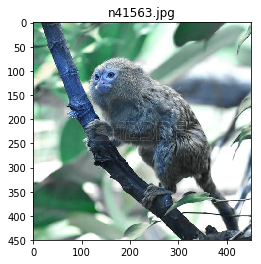

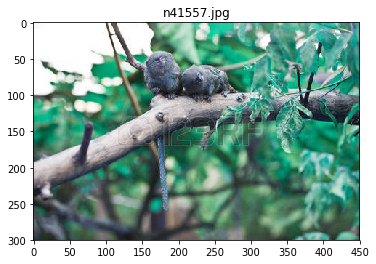

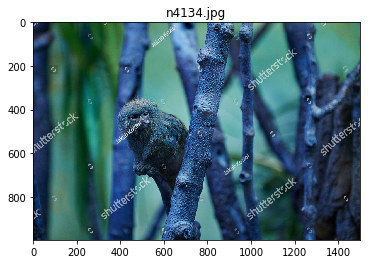

In [15]:
print(labels[4])
image_show(3,'n4')

In [16]:
LR = 1e-3
height=150
width=150
channels=3
seed=1337
batch_size = 64
num_classes = 10
epochs = 200
data_augmentation = True
num_predictions = 20

# Training generator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(height,width),
                                                    batch_size=batch_size,
                                                    seed=seed,
                                                    shuffle=True,
                                                    class_mode='categorical')

# Test generator
test_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(height,width), 
                                                  batch_size=batch_size,
                                                  seed=seed,
                                                  shuffle=False,
                                                  class_mode='categorical')

train_num = train_generator.samples
validation_num = validation_generator.samples 

Found 1097 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [17]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

The model needs to be compiled before training can start. As our loss function, we use logloss which is called ''categorical_crossentropy" in Keras. Metrics is only used for evaluation. As optimizer, we could have used ordinary stochastic gradient descent (SGD), but Adam is faster.

In [18]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 36, 36, 64)        18496     
__________

In [19]:
filepath=str(os.getcwd()+"/model.h5f")
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# = EarlyStopping(monitor='val_acc', patience=15)
callbacks_list = [checkpoint]#, stopper]

In [20]:
history = model.fit_generator(train_generator,
                              steps_per_epoch= train_num // batch_size,
                              epochs=epochs,
                              validation_data=train_generator,
                              validation_steps= validation_num // batch_size,
                              callbacks=callbacks_list, 
                              verbose = 1
                             )

Epoch 1/200
17/17 [==============================] - ETA: 4:18 - loss: 2.3115 - acc: 0.140 - ETA: 2:03 - loss: 2.3285 - acc: 0.117 - ETA: 1:18 - loss: 2.3249 - acc: 0.114 - ETA: 55s - loss: 2.3253 - acc: 0.113 - ETA: 42s - loss: 2.3137 - acc: 0.12 - ETA: 41s - loss: 2.3113 - acc: 0.11 - ETA: 39s - loss: 2.3056 - acc: 0.12 - ETA: 35s - loss: 2.3109 - acc: 0.11 - ETA: 29s - loss: 2.3079 - acc: 0.12 - ETA: 26s - loss: 2.3027 - acc: 0.12 - ETA: 22s - loss: 2.2982 - acc: 0.12 - ETA: 17s - loss: 2.2934 - acc: 0.12 - ETA: 13s - loss: 2.2833 - acc: 0.13 - ETA: 9s - loss: 2.2759 - acc: 0.1406 - ETA: 6s - loss: 2.2727 - acc: 0.143 - ETA: 3s - loss: 2.2640 - acc: 0.147 - 54s 3s/step - loss: 2.2614 - acc: 0.1498 - val_loss: 2.1218 - val_acc: 0.1992

Epoch 00001: val_acc improved from -inf to 0.19922, saving model to D:\API\Studying/model.h5f
Epoch 2/200
17/17 [==============================] - ETA: 42s - loss: 2.1250 - acc: 0.25 - ETA: 44s - loss: 2.0542 - acc: 0.28 - ETA: 44s - loss: 2.0289 - acc


Epoch 00010: val_acc improved from 0.56250 to 0.57214, saving model to D:\API\Studying/model.h5f
Epoch 11/200
17/17 [==============================] - ETA: 31s - loss: 1.3904 - acc: 0.39 - ETA: 31s - loss: 1.4209 - acc: 0.42 - ETA: 29s - loss: 1.3447 - acc: 0.47 - ETA: 31s - loss: 1.3389 - acc: 0.47 - ETA: 28s - loss: 1.2914 - acc: 0.49 - ETA: 25s - loss: 1.2972 - acc: 0.50 - ETA: 23s - loss: 1.3107 - acc: 0.49 - ETA: 22s - loss: 1.2833 - acc: 0.49 - ETA: 22s - loss: 1.2924 - acc: 0.49 - ETA: 19s - loss: 1.3360 - acc: 0.48 - ETA: 16s - loss: 1.3498 - acc: 0.48 - ETA: 14s - loss: 1.3540 - acc: 0.48 - ETA: 10s - loss: 1.4359 - acc: 0.47 - ETA: 8s - loss: 1.4100 - acc: 0.4881 - ETA: 5s - loss: 1.4109 - acc: 0.487 - ETA: 2s - loss: 1.4110 - acc: 0.496 - 46s 3s/step - loss: 1.4172 - acc: 0.4953 - val_loss: 1.3605 - val_acc: 0.4932

Epoch 00011: val_acc did not improve from 0.57214
Epoch 12/200
17/17 [==============================] - ETA: 50s - loss: 1.4567 - acc: 0.45 - ETA: 47s - loss: 1


Epoch 00020: val_acc did not improve from 0.68750
Epoch 21/200
17/17 [==============================] - ETA: 32s - loss: 0.9817 - acc: 0.70 - ETA: 35s - loss: 0.9036 - acc: 0.72 - ETA: 23s - loss: 1.1494 - acc: 0.63 - ETA: 23s - loss: 1.1075 - acc: 0.64 - ETA: 21s - loss: 1.0723 - acc: 0.64 - ETA: 20s - loss: 1.1292 - acc: 0.61 - ETA: 18s - loss: 1.1350 - acc: 0.61 - ETA: 16s - loss: 1.1358 - acc: 0.61 - ETA: 15s - loss: 1.1139 - acc: 0.62 - ETA: 13s - loss: 1.1050 - acc: 0.62 - ETA: 12s - loss: 1.1198 - acc: 0.61 - ETA: 10s - loss: 1.1257 - acc: 0.60 - ETA: 8s - loss: 1.1448 - acc: 0.5931 - ETA: 6s - loss: 1.1530 - acc: 0.586 - ETA: 4s - loss: 1.1480 - acc: 0.585 - ETA: 2s - loss: 1.1433 - acc: 0.585 - 38s 2s/step - loss: 1.1580 - acc: 0.5799 - val_loss: 1.0887 - val_acc: 0.6406

Epoch 00021: val_acc did not improve from 0.68750
Epoch 22/200
17/17 [==============================] - ETA: 39s - loss: 0.9979 - acc: 0.67 - ETA: 41s - loss: 0.9817 - acc: 0.61 - ETA: 40s - loss: 0.9991 - a

17/17 [==============================] - ETA: 24s - loss: 0.9179 - acc: 0.70 - ETA: 25s - loss: 0.8317 - acc: 0.71 - ETA: 26s - loss: 0.8735 - acc: 0.70 - ETA: 27s - loss: 0.9159 - acc: 0.69 - ETA: 26s - loss: 0.9658 - acc: 0.69 - ETA: 26s - loss: 0.9507 - acc: 0.68 - ETA: 20s - loss: 0.9828 - acc: 0.71 - ETA: 19s - loss: 0.9664 - acc: 0.71 - ETA: 17s - loss: 0.9622 - acc: 0.70 - ETA: 15s - loss: 0.9479 - acc: 0.70 - ETA: 13s - loss: 0.9485 - acc: 0.70 - ETA: 11s - loss: 0.9599 - acc: 0.69 - ETA: 9s - loss: 0.9497 - acc: 0.6946 - ETA: 6s - loss: 0.9547 - acc: 0.689 - ETA: 4s - loss: 0.9486 - acc: 0.690 - ETA: 2s - loss: 0.9509 - acc: 0.688 - 38s 2s/step - loss: 0.9548 - acc: 0.6868 - val_loss: 0.8289 - val_acc: 0.6875

Epoch 00031: val_acc did not improve from 0.71875
Epoch 32/200
17/17 [==============================] - ETA: 30s - loss: 0.8259 - acc: 0.64 - ETA: 43s - loss: 0.9561 - acc: 0.60 - ETA: 43s - loss: 1.0563 - acc: 0.56 - ETA: 30s - loss: 1.1887 - acc: 0.50 - ETA: 29s - loss

17/17 [==============================] - ETA: 1:06 - loss: 0.7673 - acc: 0.671 - ETA: 47s - loss: 0.7403 - acc: 0.687 - ETA: 39s - loss: 0.7329 - acc: 0.69 - ETA: 37s - loss: 0.7720 - acc: 0.68 - ETA: 30s - loss: 0.8478 - acc: 0.68 - ETA: 28s - loss: 0.8819 - acc: 0.66 - ETA: 24s - loss: 0.8870 - acc: 0.66 - ETA: 22s - loss: 0.8722 - acc: 0.67 - ETA: 19s - loss: 0.8845 - acc: 0.67 - ETA: 17s - loss: 0.8747 - acc: 0.67 - ETA: 14s - loss: 0.8695 - acc: 0.68 - ETA: 12s - loss: 0.8491 - acc: 0.69 - ETA: 8s - loss: 0.8380 - acc: 0.7005 - ETA: 6s - loss: 0.8352 - acc: 0.705 - ETA: 4s - loss: 0.8366 - acc: 0.708 - ETA: 2s - loss: 0.8219 - acc: 0.710 - 38s 2s/step - loss: 0.8182 - acc: 0.7110 - val_loss: 0.6998 - val_acc: 0.7910

Epoch 00041: val_acc improved from 0.77734 to 0.79104, saving model to D:\API\Studying/model.h5f
Epoch 42/200
17/17 [==============================] - ETA: 30s - loss: 0.7794 - acc: 0.67 - ETA: 40s - loss: 0.9563 - acc: 0.66 - ETA: 36s - loss: 0.8726 - acc: 0.70 - ETA

17/17 [==============================] - ETA: 35s - loss: 0.5406 - acc: 0.79 - ETA: 34s - loss: 0.5796 - acc: 0.76 - ETA: 22s - loss: 0.6298 - acc: 0.73 - ETA: 23s - loss: 0.6623 - acc: 0.73 - ETA: 24s - loss: 0.6479 - acc: 0.75 - ETA: 23s - loss: 0.6477 - acc: 0.75 - ETA: 20s - loss: 0.6398 - acc: 0.76 - ETA: 18s - loss: 0.6462 - acc: 0.75 - ETA: 17s - loss: 0.6651 - acc: 0.75 - ETA: 14s - loss: 0.6633 - acc: 0.75 - ETA: 12s - loss: 0.6655 - acc: 0.75 - ETA: 10s - loss: 0.6745 - acc: 0.75 - ETA: 8s - loss: 0.6696 - acc: 0.7580 - ETA: 6s - loss: 0.6648 - acc: 0.755 - ETA: 4s - loss: 0.6678 - acc: 0.753 - ETA: 2s - loss: 0.6709 - acc: 0.750 - 35s 2s/step - loss: 0.6786 - acc: 0.7490 - val_loss: 0.4915 - val_acc: 0.8281

Epoch 00051: val_acc improved from 0.81592 to 0.82812, saving model to D:\API\Studying/model.h5f
Epoch 52/200
17/17 [==============================] - ETA: 41s - loss: 0.5005 - acc: 0.85 - ETA: 40s - loss: 0.5351 - acc: 0.81 - ETA: 33s - loss: 0.5348 - acc: 0.82 - ETA: 3

17/17 [==============================] - ETA: 20s - loss: 0.6452 - acc: 0.75 - ETA: 25s - loss: 0.7864 - acc: 0.73 - ETA: 28s - loss: 0.7400 - acc: 0.74 - ETA: 28s - loss: 0.7763 - acc: 0.72 - ETA: 25s - loss: 0.7383 - acc: 0.72 - ETA: 23s - loss: 0.7476 - acc: 0.72 - ETA: 18s - loss: 0.7795 - acc: 0.70 - ETA: 16s - loss: 0.7628 - acc: 0.70 - ETA: 15s - loss: 0.7484 - acc: 0.70 - ETA: 13s - loss: 0.7537 - acc: 0.70 - ETA: 11s - loss: 0.7680 - acc: 0.70 - ETA: 9s - loss: 0.7435 - acc: 0.7195 - ETA: 7s - loss: 0.7413 - acc: 0.725 - ETA: 5s - loss: 0.7397 - acc: 0.726 - ETA: 3s - loss: 0.7475 - acc: 0.722 - ETA: 2s - loss: 0.7371 - acc: 0.727 - 35s 2s/step - loss: 0.7396 - acc: 0.7225 - val_loss: 0.6588 - val_acc: 0.7461

Epoch 00061: val_acc did not improve from 0.87109
Epoch 62/200
17/17 [==============================] - ETA: 52s - loss: 0.7629 - acc: 0.68 - ETA: 45s - loss: 0.7338 - acc: 0.72 - ETA: 36s - loss: 0.6823 - acc: 0.76 - ETA: 26s - loss: 0.6529 - acc: 0.76 - ETA: 23s - loss

17/17 [==============================] - ETA: 51s - loss: 0.3634 - acc: 0.84 - ETA: 38s - loss: 0.3992 - acc: 0.84 - ETA: 33s - loss: 0.4555 - acc: 0.82 - ETA: 32s - loss: 0.4677 - acc: 0.82 - ETA: 29s - loss: 0.4472 - acc: 0.83 - ETA: 26s - loss: 0.4451 - acc: 0.83 - ETA: 24s - loss: 0.4335 - acc: 0.84 - ETA: 22s - loss: 0.4429 - acc: 0.83 - ETA: 20s - loss: 0.4443 - acc: 0.83 - ETA: 17s - loss: 0.4454 - acc: 0.84 - ETA: 14s - loss: 0.4491 - acc: 0.84 - ETA: 11s - loss: 0.4703 - acc: 0.83 - ETA: 8s - loss: 0.4807 - acc: 0.8303 - ETA: 6s - loss: 0.4780 - acc: 0.829 - ETA: 4s - loss: 0.4830 - acc: 0.822 - ETA: 2s - loss: 0.4911 - acc: 0.823 - 36s 2s/step - loss: 0.4939 - acc: 0.8216 - val_loss: 0.3791 - val_acc: 0.8493

Epoch 00071: val_acc did not improve from 0.88281
Epoch 72/200
17/17 [==============================] - ETA: 31s - loss: 0.5242 - acc: 0.76 - ETA: 37s - loss: 0.4875 - acc: 0.80 - ETA: 31s - loss: 0.5010 - acc: 0.81 - ETA: 28s - loss: 0.5575 - acc: 0.79 - ETA: 27s - loss

17/17 [==============================] - ETA: 26s - loss: 0.5262 - acc: 0.81 - ETA: 30s - loss: 0.5449 - acc: 0.81 - ETA: 19s - loss: 0.4506 - acc: 0.83 - ETA: 23s - loss: 0.5129 - acc: 0.82 - ETA: 25s - loss: 0.5137 - acc: 0.82 - ETA: 24s - loss: 0.5037 - acc: 0.82 - ETA: 23s - loss: 0.5226 - acc: 0.81 - ETA: 21s - loss: 0.5326 - acc: 0.82 - ETA: 18s - loss: 0.5331 - acc: 0.82 - ETA: 15s - loss: 0.5358 - acc: 0.81 - ETA: 13s - loss: 0.5286 - acc: 0.81 - ETA: 11s - loss: 0.5251 - acc: 0.81 - ETA: 8s - loss: 0.5222 - acc: 0.8184 - ETA: 6s - loss: 0.5116 - acc: 0.821 - ETA: 4s - loss: 0.5218 - acc: 0.817 - ETA: 2s - loss: 0.5156 - acc: 0.821 - 37s 2s/step - loss: 0.5117 - acc: 0.8214 - val_loss: 0.3117 - val_acc: 0.9141

Epoch 00081: val_acc improved from 0.90050 to 0.91406, saving model to D:\API\Studying/model.h5f
Epoch 82/200
17/17 [==============================] - ETA: 30s - loss: 0.4065 - acc: 0.82 - ETA: 30s - loss: 0.4323 - acc: 0.82 - ETA: 27s - loss: 0.4304 - acc: 0.83 - ETA: 2

17/17 [==============================] - ETA: 33s - loss: 0.4255 - acc: 0.89 - ETA: 35s - loss: 0.4430 - acc: 0.86 - ETA: 33s - loss: 0.4233 - acc: 0.85 - ETA: 32s - loss: 0.4675 - acc: 0.85 - ETA: 28s - loss: 0.4611 - acc: 0.85 - ETA: 25s - loss: 0.4886 - acc: 0.83 - ETA: 19s - loss: 0.4690 - acc: 0.84 - ETA: 18s - loss: 0.4520 - acc: 0.85 - ETA: 16s - loss: 0.4801 - acc: 0.84 - ETA: 14s - loss: 0.4986 - acc: 0.83 - ETA: 12s - loss: 0.5003 - acc: 0.83 - ETA: 10s - loss: 0.4936 - acc: 0.83 - ETA: 8s - loss: 0.4927 - acc: 0.8376 - ETA: 6s - loss: 0.5063 - acc: 0.832 - ETA: 4s - loss: 0.5088 - acc: 0.834 - ETA: 2s - loss: 0.5088 - acc: 0.834 - 38s 2s/step - loss: 0.5132 - acc: 0.8352 - val_loss: 0.3305 - val_acc: 0.8984

Epoch 00091: val_acc did not improve from 0.91406
Epoch 92/200
17/17 [==============================] - ETA: 25s - loss: 0.3769 - acc: 0.84 - ETA: 30s - loss: 0.3029 - acc: 0.87 - ETA: 27s - loss: 0.3724 - acc: 0.86 - ETA: 28s - loss: 0.3615 - acc: 0.87 - ETA: 26s - loss

17/17 [==============================] - ETA: 33s - loss: 0.4312 - acc: 0.85 - ETA: 30s - loss: 0.3556 - acc: 0.88 - ETA: 30s - loss: 0.3360 - acc: 0.88 - ETA: 32s - loss: 0.3535 - acc: 0.87 - ETA: 29s - loss: 0.3483 - acc: 0.87 - ETA: 27s - loss: 0.3466 - acc: 0.86 - ETA: 23s - loss: 0.3561 - acc: 0.86 - ETA: 21s - loss: 0.3875 - acc: 0.86 - ETA: 18s - loss: 0.3775 - acc: 0.86 - ETA: 15s - loss: 0.3700 - acc: 0.86 - ETA: 13s - loss: 0.3633 - acc: 0.86 - ETA: 11s - loss: 0.3770 - acc: 0.86 - ETA: 8s - loss: 0.3992 - acc: 0.8420 - ETA: 6s - loss: 0.4026 - acc: 0.842 - ETA: 4s - loss: 0.4280 - acc: 0.837 - ETA: 2s - loss: 0.4485 - acc: 0.834 - 35s 2s/step - loss: 0.4543 - acc: 0.8359 - val_loss: 0.6474 - val_acc: 0.7945

Epoch 00101: val_acc did not improve from 0.93359
Epoch 102/200
17/17 [==============================] - ETA: 42s - loss: 0.5706 - acc: 0.81 - ETA: 47s - loss: 0.5319 - acc: 0.82 - ETA: 39s - loss: 0.5569 - acc: 0.81 - ETA: 35s - loss: 0.5629 - acc: 0.80 - ETA: 31s - los

17/17 [==============================] - ETA: 26s - loss: 0.2064 - acc: 0.93 - ETA: 32s - loss: 0.2266 - acc: 0.93 - ETA: 22s - loss: 0.4154 - acc: 0.84 - ETA: 25s - loss: 0.3892 - acc: 0.85 - ETA: 23s - loss: 0.3834 - acc: 0.86 - ETA: 21s - loss: 0.4132 - acc: 0.85 - ETA: 18s - loss: 0.4010 - acc: 0.84 - ETA: 17s - loss: 0.3961 - acc: 0.84 - ETA: 15s - loss: 0.3952 - acc: 0.84 - ETA: 14s - loss: 0.3830 - acc: 0.85 - ETA: 12s - loss: 0.3973 - acc: 0.84 - ETA: 10s - loss: 0.4077 - acc: 0.84 - ETA: 8s - loss: 0.3969 - acc: 0.8470 - ETA: 6s - loss: 0.3973 - acc: 0.847 - ETA: 4s - loss: 0.3948 - acc: 0.851 - ETA: 2s - loss: 0.4070 - acc: 0.851 - 37s 2s/step - loss: 0.4032 - acc: 0.8532 - val_loss: 0.2117 - val_acc: 0.9336

Epoch 00111: val_acc did not improve from 0.93359
Epoch 112/200
17/17 [==============================] - ETA: 16s - loss: 0.2258 - acc: 0.92 - ETA: 25s - loss: 0.2520 - acc: 0.90 - ETA: 26s - loss: 0.2559 - acc: 0.90 - ETA: 26s - loss: 0.2348 - acc: 0.91 - ETA: 25s - los

17/17 [==============================] - ETA: 47s - loss: 0.4141 - acc: 0.84 - ETA: 51s - loss: 0.3804 - acc: 0.89 - ETA: 58s - loss: 0.3940 - acc: 0.89 - ETA: 51s - loss: 0.3715 - acc: 0.89 - ETA: 49s - loss: 0.3444 - acc: 0.90 - ETA: 45s - loss: 0.3614 - acc: 0.88 - ETA: 36s - loss: 0.3133 - acc: 0.90 - ETA: 33s - loss: 0.3207 - acc: 0.89 - ETA: 29s - loss: 0.3199 - acc: 0.89 - ETA: 25s - loss: 0.3155 - acc: 0.89 - ETA: 21s - loss: 0.3103 - acc: 0.89 - ETA: 17s - loss: 0.3176 - acc: 0.89 - ETA: 14s - loss: 0.3056 - acc: 0.89 - ETA: 10s - loss: 0.3034 - acc: 0.89 - ETA: 7s - loss: 0.2997 - acc: 0.8969 - ETA: 3s - loss: 0.2963 - acc: 0.898 - 60s 4s/step - loss: 0.3004 - acc: 0.8977 - val_loss: 0.2492 - val_acc: 0.9141

Epoch 00121: val_acc did not improve from 0.94531
Epoch 122/200
17/17 [==============================] - ETA: 44s - loss: 0.2854 - acc: 0.87 - ETA: 54s - loss: 0.2986 - acc: 0.89 - ETA: 55s - loss: 0.3078 - acc: 0.87 - ETA: 57s - loss: 0.2901 - acc: 0.89 - ETA: 50s - los

17/17 [==============================] - ETA: 57s - loss: 0.2638 - acc: 0.96 - ETA: 1:21 - loss: 0.3105 - acc: 0.937 - ETA: 1:36 - loss: 0.2907 - acc: 0.927 - ETA: 1:22 - loss: 0.2994 - acc: 0.929 - ETA: 1:14 - loss: 0.3186 - acc: 0.909 - ETA: 1:02 - loss: 0.3208 - acc: 0.901 - ETA: 53s - loss: 0.3171 - acc: 0.904 - ETA: 45s - loss: 0.3097 - acc: 0.90 - ETA: 39s - loss: 0.3050 - acc: 0.90 - ETA: 35s - loss: 0.3032 - acc: 0.90 - ETA: 29s - loss: 0.3082 - acc: 0.90 - ETA: 24s - loss: 0.3069 - acc: 0.89 - ETA: 18s - loss: 0.3074 - acc: 0.89 - ETA: 13s - loss: 0.3059 - acc: 0.89 - ETA: 8s - loss: 0.2966 - acc: 0.8946 - ETA: 4s - loss: 0.2949 - acc: 0.893 - 76s 4s/step - loss: 0.3099 - acc: 0.8898 - val_loss: 0.1657 - val_acc: 0.9552

Epoch 00131: val_acc improved from 0.95312 to 0.95522, saving model to D:\API\Studying/model.h5f
Epoch 132/200
17/17 [==============================] - ETA: 58s - loss: 0.2943 - acc: 0.92 - ETA: 1:03 - loss: 0.3075 - acc: 0.890 - ETA: 1:00 - loss: 0.2805 - acc

17/17 [==============================] - ETA: 47s - loss: 0.2468 - acc: 0.92 - ETA: 59s - loss: 0.3817 - acc: 0.89 - ETA: 39s - loss: 0.3083 - acc: 0.92 - ETA: 37s - loss: 0.2645 - acc: 0.93 - ETA: 38s - loss: 0.2580 - acc: 0.93 - ETA: 36s - loss: 0.2446 - acc: 0.93 - ETA: 33s - loss: 0.2440 - acc: 0.92 - ETA: 31s - loss: 0.2528 - acc: 0.91 - ETA: 27s - loss: 0.2537 - acc: 0.91 - ETA: 23s - loss: 0.2465 - acc: 0.91 - ETA: 20s - loss: 0.2380 - acc: 0.91 - ETA: 17s - loss: 0.2436 - acc: 0.92 - ETA: 14s - loss: 0.2430 - acc: 0.92 - ETA: 11s - loss: 0.2559 - acc: 0.92 - ETA: 7s - loss: 0.2534 - acc: 0.9229 - ETA: 3s - loss: 0.2549 - acc: 0.920 - 63s 4s/step - loss: 0.2503 - acc: 0.9216 - val_loss: 0.1491 - val_acc: 0.9570

Epoch 00141: val_acc improved from 0.95522 to 0.95703, saving model to D:\API\Studying/model.h5f
Epoch 142/200
17/17 [==============================] - ETA: 46s - loss: 0.4898 - acc: 0.84 - ETA: 49s - loss: 0.3239 - acc: 0.88 - ETA: 50s - loss: 0.3081 - acc: 0.89 - ETA: 

17/17 [==============================] - ETA: 44s - loss: 0.2869 - acc: 0.89 - ETA: 59s - loss: 0.2455 - acc: 0.90 - ETA: 58s - loss: 0.2393 - acc: 0.91 - ETA: 54s - loss: 0.2366 - acc: 0.92 - ETA: 47s - loss: 0.2637 - acc: 0.91 - ETA: 44s - loss: 0.2804 - acc: 0.90 - ETA: 35s - loss: 0.2435 - acc: 0.91 - ETA: 31s - loss: 0.2598 - acc: 0.91 - ETA: 28s - loss: 0.2694 - acc: 0.90 - ETA: 24s - loss: 0.2821 - acc: 0.90 - ETA: 20s - loss: 0.2674 - acc: 0.90 - ETA: 16s - loss: 0.2660 - acc: 0.90 - ETA: 13s - loss: 0.2730 - acc: 0.90 - ETA: 10s - loss: 0.2746 - acc: 0.90 - ETA: 6s - loss: 0.2767 - acc: 0.9073 - ETA: 3s - loss: 0.2738 - acc: 0.907 - 61s 4s/step - loss: 0.2696 - acc: 0.9087 - val_loss: 0.1460 - val_acc: 0.9609

Epoch 00151: val_acc did not improve from 0.98047
Epoch 152/200
17/17 [==============================] - ETA: 58s - loss: 0.1207 - acc: 0.96 - ETA: 55s - loss: 0.2125 - acc: 0.93 - ETA: 49s - loss: 0.2018 - acc: 0.92 - ETA: 49s - loss: 0.2361 - acc: 0.91 - ETA: 43s - los

17/17 [==============================] - ETA: 45s - loss: 0.3843 - acc: 0.87 - ETA: 50s - loss: 0.3789 - acc: 0.88 - ETA: 51s - loss: 0.3592 - acc: 0.88 - ETA: 50s - loss: 0.3757 - acc: 0.86 - ETA: 46s - loss: 0.3914 - acc: 0.85 - ETA: 41s - loss: 0.3954 - acc: 0.85 - ETA: 37s - loss: 0.3797 - acc: 0.85 - ETA: 33s - loss: 0.3823 - acc: 0.85 - ETA: 29s - loss: 0.3967 - acc: 0.86 - ETA: 27s - loss: 0.3797 - acc: 0.87 - ETA: 23s - loss: 0.3909 - acc: 0.86 - ETA: 19s - loss: 0.3922 - acc: 0.86 - ETA: 14s - loss: 0.3635 - acc: 0.87 - ETA: 11s - loss: 0.3716 - acc: 0.87 - ETA: 7s - loss: 0.3795 - acc: 0.8760 - ETA: 3s - loss: 0.3690 - acc: 0.878 - 63s 4s/step - loss: 0.3739 - acc: 0.8774 - val_loss: 0.2327 - val_acc: 0.9204

Epoch 00161: val_acc did not improve from 0.98047
Epoch 162/200
17/17 [==============================] - ETA: 38s - loss: 0.3865 - acc: 0.85 - ETA: 50s - loss: 0.2767 - acc: 0.90 - ETA: 53s - loss: 0.2863 - acc: 0.89 - ETA: 49s - loss: 0.2514 - acc: 0.90 - ETA: 46s - los

17/17 [==============================] - ETA: 1:10 - loss: 0.2850 - acc: 0.921 - ETA: 1:04 - loss: 0.2881 - acc: 0.890 - ETA: 43s - loss: 0.2765 - acc: 0.853 - ETA: 47s - loss: 0.2445 - acc: 0.88 - ETA: 46s - loss: 0.2784 - acc: 0.87 - ETA: 44s - loss: 0.2644 - acc: 0.88 - ETA: 38s - loss: 0.2875 - acc: 0.88 - ETA: 35s - loss: 0.2813 - acc: 0.89 - ETA: 31s - loss: 0.2742 - acc: 0.89 - ETA: 27s - loss: 0.2632 - acc: 0.89 - ETA: 23s - loss: 0.2554 - acc: 0.90 - ETA: 19s - loss: 0.2668 - acc: 0.89 - ETA: 15s - loss: 0.2569 - acc: 0.90 - ETA: 11s - loss: 0.2536 - acc: 0.90 - ETA: 7s - loss: 0.2485 - acc: 0.9060 - ETA: 3s - loss: 0.2400 - acc: 0.909 - 67s 4s/step - loss: 0.2379 - acc: 0.9101 - val_loss: 0.1049 - val_acc: 0.9688

Epoch 00171: val_acc did not improve from 0.98047
Epoch 172/200
17/17 [==============================] - ETA: 55s - loss: 0.1457 - acc: 0.95 - ETA: 1:07 - loss: 0.1847 - acc: 0.921 - ETA: 1:00 - loss: 0.1632 - acc: 0.937 - ETA: 54s - loss: 0.1511 - acc: 0.945 - ETA:

17/17 [==============================] - ETA: 44s - loss: 0.4057 - acc: 0.85 - ETA: 50s - loss: 0.2842 - acc: 0.90 - ETA: 46s - loss: 0.3138 - acc: 0.89 - ETA: 46s - loss: 0.2706 - acc: 0.91 - ETA: 44s - loss: 0.2605 - acc: 0.91 - ETA: 39s - loss: 0.2634 - acc: 0.91 - ETA: 31s - loss: 0.3556 - acc: 0.91 - ETA: 27s - loss: 0.3375 - acc: 0.91 - ETA: 24s - loss: 0.3189 - acc: 0.91 - ETA: 21s - loss: 0.3142 - acc: 0.91 - ETA: 18s - loss: 0.3174 - acc: 0.91 - ETA: 15s - loss: 0.3275 - acc: 0.90 - ETA: 12s - loss: 0.3160 - acc: 0.90 - ETA: 9s - loss: 0.3163 - acc: 0.9084 - ETA: 6s - loss: 0.3158 - acc: 0.906 - ETA: 3s - loss: 0.3317 - acc: 0.900 - 55s 3s/step - loss: 0.3226 - acc: 0.8997 - val_loss: 0.2389 - val_acc: 0.9297

Epoch 00181: val_acc did not improve from 0.98047
Epoch 182/200
17/17 [==============================] - ETA: 1:10 - loss: 0.3627 - acc: 0.843 - ETA: 1:12 - loss: 0.3539 - acc: 0.859 - ETA: 1:04 - loss: 0.3057 - acc: 0.885 - ETA: 59s - loss: 0.2692 - acc: 0.894 - ETA: 50

17/17 [==============================] - ETA: 55s - loss: 0.0713 - acc: 0.98 - ETA: 1:07 - loss: 0.0846 - acc: 0.968 - ETA: 1:07 - loss: 0.0847 - acc: 0.963 - ETA: 1:01 - loss: 0.1398 - acc: 0.941 - ETA: 57s - loss: 0.1284 - acc: 0.950 - ETA: 51s - loss: 0.1778 - acc: 0.93 - ETA: 46s - loss: 0.1758 - acc: 0.93 - ETA: 40s - loss: 0.1676 - acc: 0.93 - ETA: 38s - loss: 0.1617 - acc: 0.93 - ETA: 34s - loss: 0.1706 - acc: 0.93 - ETA: 28s - loss: 0.1664 - acc: 0.94 - ETA: 23s - loss: 0.1632 - acc: 0.94 - ETA: 17s - loss: 0.2194 - acc: 0.92 - ETA: 13s - loss: 0.2149 - acc: 0.92 - ETA: 8s - loss: 0.2386 - acc: 0.9174 - ETA: 4s - loss: 0.2514 - acc: 0.911 - 72s 4s/step - loss: 0.2807 - acc: 0.9076 - val_loss: 0.2568 - val_acc: 0.9154

Epoch 00191: val_acc did not improve from 0.98047
Epoch 192/200
17/17 [==============================] - ETA: 1:38 - loss: 0.3016 - acc: 0.906 - ETA: 1:25 - loss: 0.2809 - acc: 0.875 - ETA: 1:17 - loss: 0.2791 - acc: 0.890 - ETA: 1:06 - loss: 0.2755 - acc: 0.898 -

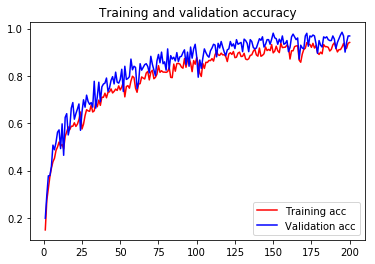

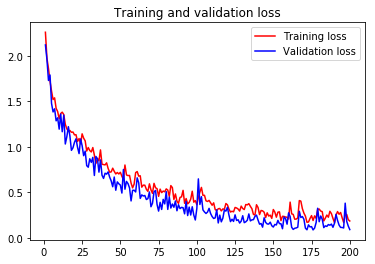

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()  

In [22]:
def plot_confusion_matrix(cm, target_names,title='Confusion matrix',cmap=None,normalize=False):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float32') / cm.sum(axis=1)
        cm = np.round(cm,2)
        

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel("Predicted label\naccuracy={:0.4f}\n misclass={:0.4f}".format(accuracy, misclass))
    plt.show()

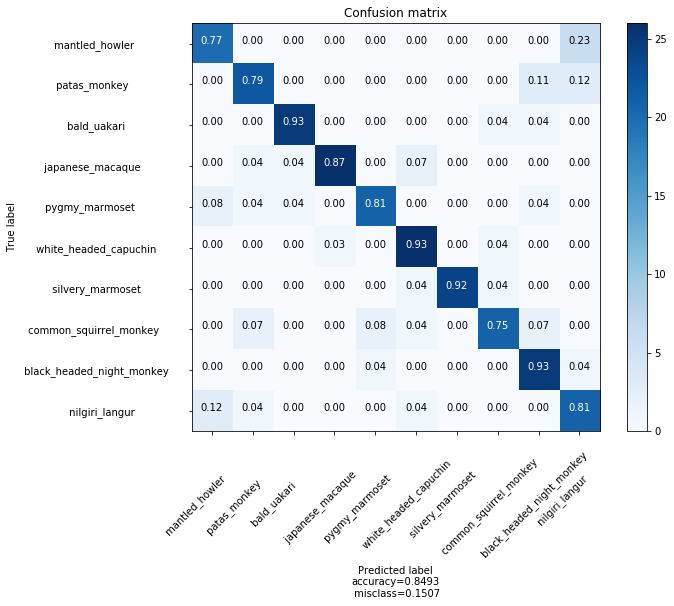

In [23]:
from keras.models import load_model
model_trained = load_model(filepath)
# Predict the values from the validation dataset
Y_pred = model_trained.predict_generator(validation_generator, validation_num // batch_size+1)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1)
# Convert validation observations to one hot vectors
#Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true = validation_generator.classes,y_pred = Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, normalize=True, target_names=labels)

In [24]:
print(metrics.classification_report(validation_generator.classes, Y_pred_classes,target_names=labels))

                                 precision    recall  f1-score   support

 mantled_howler                       0.80      0.77      0.78        26
 patas_monkey                         0.81      0.79      0.80        28
 bald_uakari                          0.93      0.93      0.93        27
 japanese_macaque                     0.96      0.87      0.91        30
 pygmy_marmoset                       0.88      0.81      0.84        26
 white_headed_capuchin                0.84      0.93      0.88        28
 silvery_marmoset                     1.00      0.92      0.96        26
 common_squirrel_monkey               0.88      0.75      0.81        28
 black_headed_night_monkey            0.78      0.93      0.85        27
 nilgiri_langur                       0.68      0.81      0.74        26

                      micro avg       0.85      0.85      0.85       272
                      macro avg       0.86      0.85      0.85       272
                   weighted avg       0.86      0